In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

### Import data

In [3]:
binance_df = pd.read_csv('../data/csv/Binance.csv')
bybit_df = pd.read_csv('../data/csv/bybit.csv')
kucoin_df = pd.read_csv('../data/csv/kuCoin.csv')
okx_df = pd.read_csv('../data/csv/okx.csv')

### Prepare the datasets

In [4]:
#drop the first column
binance_df = binance_df.drop(columns=['Unnamed: 0'])
bybit_df = bybit_df.drop(columns=['Unnamed: 0'])
kucoin_df = kucoin_df.drop(columns=['Unnamed: 0'])
okx_df = okx_df.drop(columns=['Unnamed: 0'])

In [5]:
#Group by time, average the quantities and take the last price 
binance_df = binance_df.groupby('time').agg({'price':'last', 'qty':'mean'})
bybit_df = bybit_df.groupby('time').agg({'price':'last', 'qty':'mean'})
kucoin_df = kucoin_df.groupby('time').agg({'price':'last', 'qty':'mean'})
okx_df = okx_df.groupby('time').agg({'price':'last', 'qty':'mean'})

In [6]:
binance_df_timed_index = binance_df.set_index(pd.to_datetime(binance_df.index))
bybit_df_timed_index = bybit_df.set_index(pd.to_datetime(bybit_df.index))
kucoin_df_timed_index = kucoin_df.set_index(pd.to_datetime(kucoin_df.index))
okx_df_timed_index = okx_df.set_index(pd.to_datetime(okx_df.index))

### Cross correlations on each exchanges using the Hayashi-Yoshida correlation estimator

In [144]:
def delayed_data(df1, df2, delay) : 
    delayed_df1 = df1.copy()
    df2 = df2.copy()


    delayed_df1.index = delayed_df1.index + pd.Timedelta(milliseconds= delay)

    high_time_index = min(delayed_df1.index.max(),df2.index.max())
    l_time_index = max(delayed_df1.index.min(),df2.index.min())

    df_combined = delayed_df1.join(df2, how='outer', lsuffix='_exchange1', rsuffix='_exchange2').ffill().dropna()

    return df_combined[(l_time_index<=df_combined.index) & (df_combined.index<=high_time_index)]

In [78]:
# Follow algorithm in class for the Hayashi-Yoshida correlation estimator
def hayashi_yoshida_correlation_estimator (df1, df2, delay):

    #get the dataset of the two exchanges
    combined_data = delayed_data(df1, df2, delay)

    #compute the correlation between the two exchanges
    correlation, p_value = stats.pearsonr(combined_data['price_exchange1'], combined_data['price_exchange2'])

    return correlation, p_value


### Compute correlations for distinct lags

In [146]:
def compute_laged_cross_correlation(df1 , df2 , delay_values) :
                
        #For eah delay value calculate the correlation and p-value
        hy_correlation_values = []
        hy_p_values = []

        for delay in delay_values :
                
                hy_correlation, hy_p_value = hayashi_yoshida_correlation_estimator(df1, df2, delay)
                hy_correlation_values.append(hy_correlation)
                hy_p_values.append(hy_p_value)

        return hy_correlation_values, hy_p_values

In [140]:
def plot_laged_cross_correlation (exchange1, exchange2, laged_correlation_values) :
    delay_values = range(-20000000, 20000000, 100000)

    # Set the seaborn theme
    sns.set_theme(style="darkgrid")

    # Create the plot using seaborn
    plt.figure(figsize=(10, 6))  # Optional: Adjust the figure size
    plt.plot(delay_values, laged_correlation_values,  marker='o', color='blue', label='Lagged Correlation')

    # Enhance the plot with titles and labels
    plt.title('Lagged Correlation between {} and {}'.format(exchange1, exchange2))
    plt.xlabel('Delay (ms)')
    plt.ylabel('Correlation')
    plt.show()


In [141]:
#compute the correlation between binance and bybit
binance_df_timed_index_october = binance_df_timed_index.loc['2023-10-01']
bybit_df_timed_index_october = bybit_df_timed_index.loc['2023-10-01']
okx_df_timed_index_october = okx_df_timed_index.loc['2023-10-01']
kucoin_df_timed_index_october = kucoin_df_timed_index.loc['2023-10-01']

In [135]:
delay_values = range(-20000000, 20000000, 100000)
binance_bybit_correlation_values, binance_bybit_p_values = compute_laged_cross_correlation(binance_df_timed_index_october, bybit_df_timed_index_october)

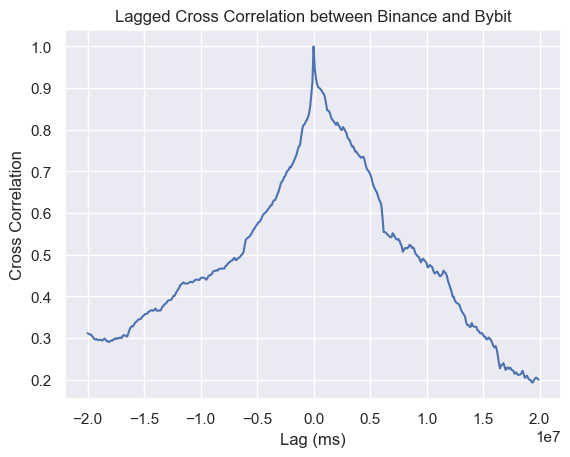

In [136]:
sns.lineplot(x= range(-20000000, 20000000, 100000), y=binance_bybit_correlation_values)
plt.title('Lagged Cross Correlation between Binance and Bybit')
plt.xlabel('Lag (ms)')
plt.ylabel('Cross Correlation')
plt.show()

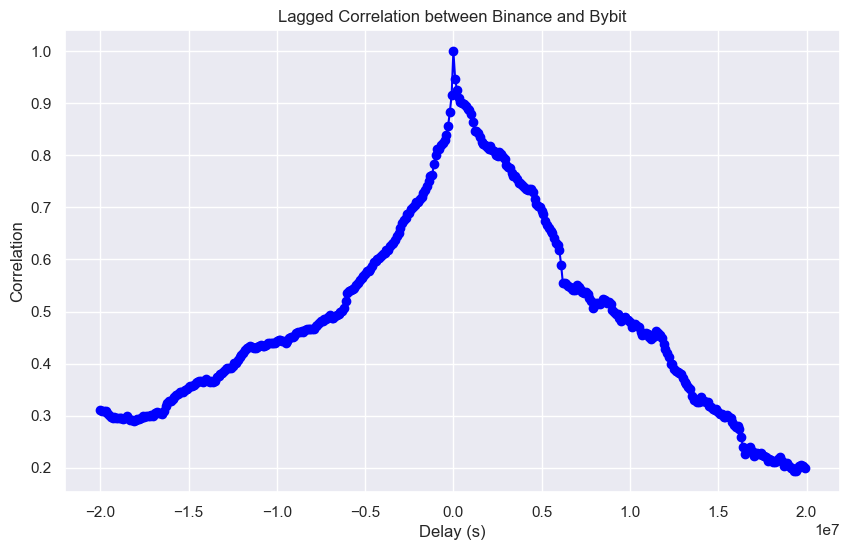

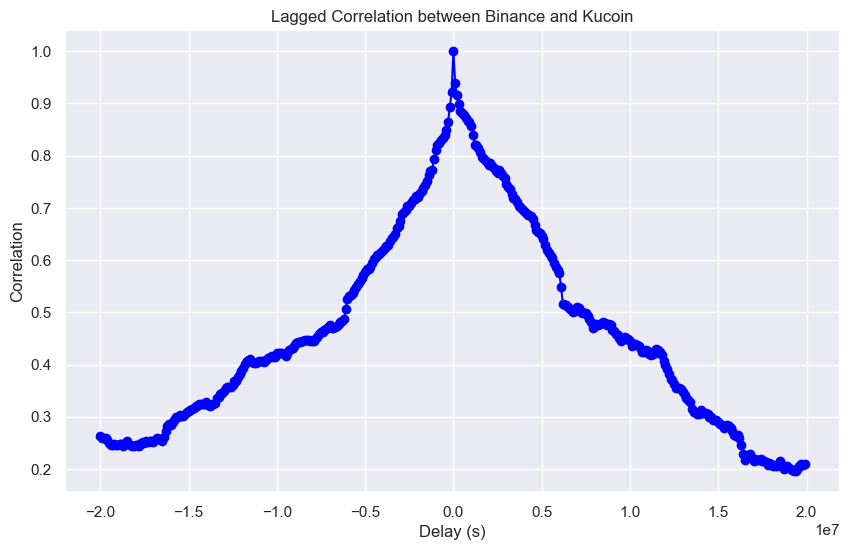

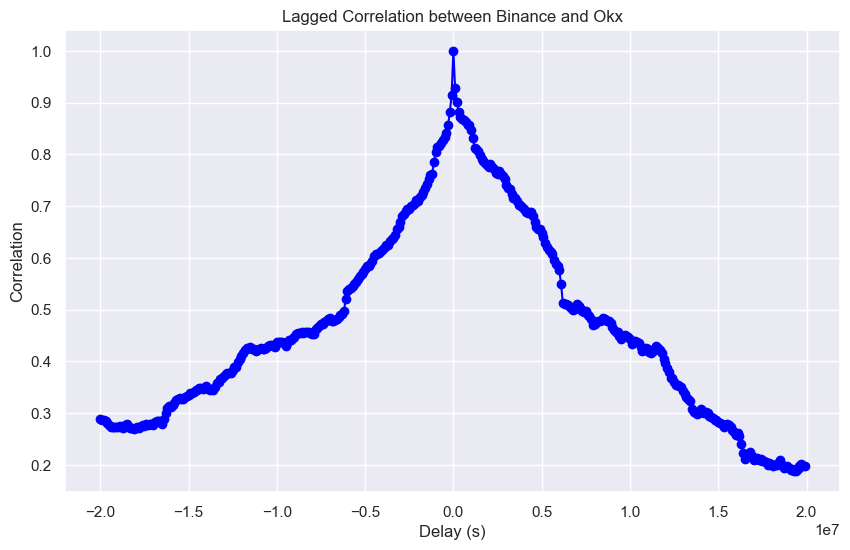

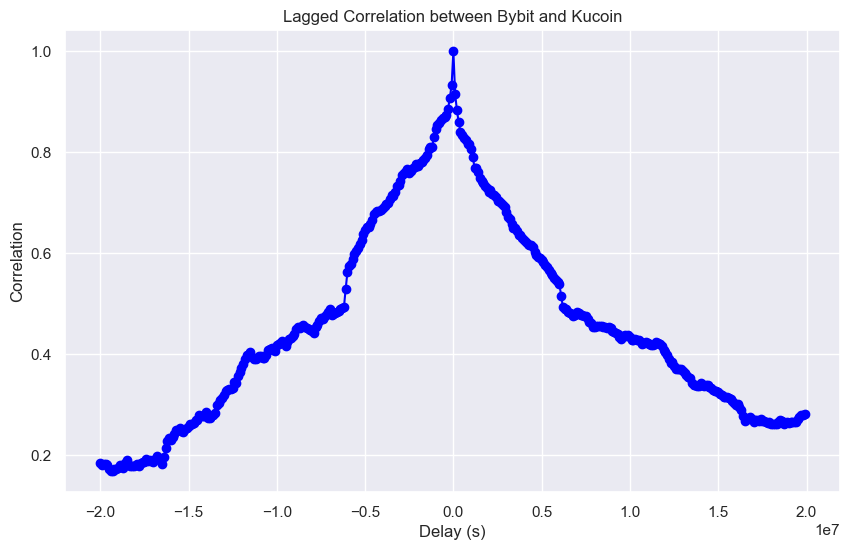

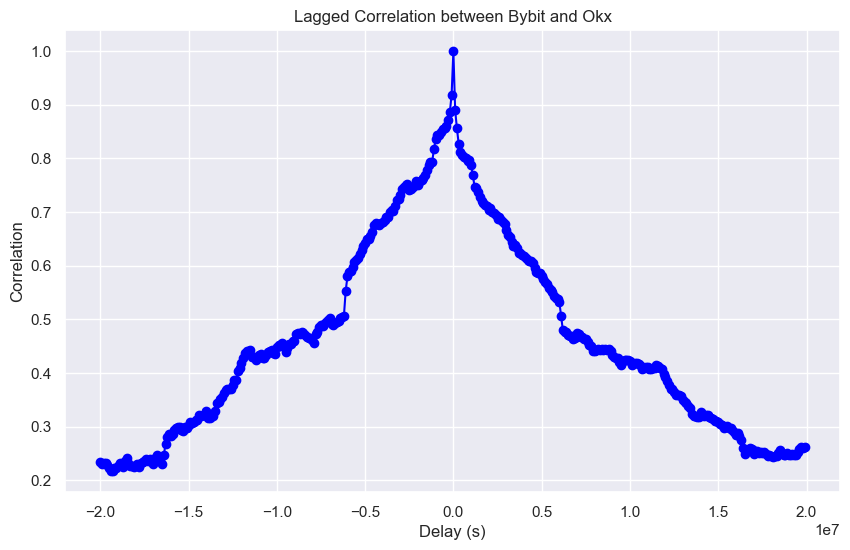

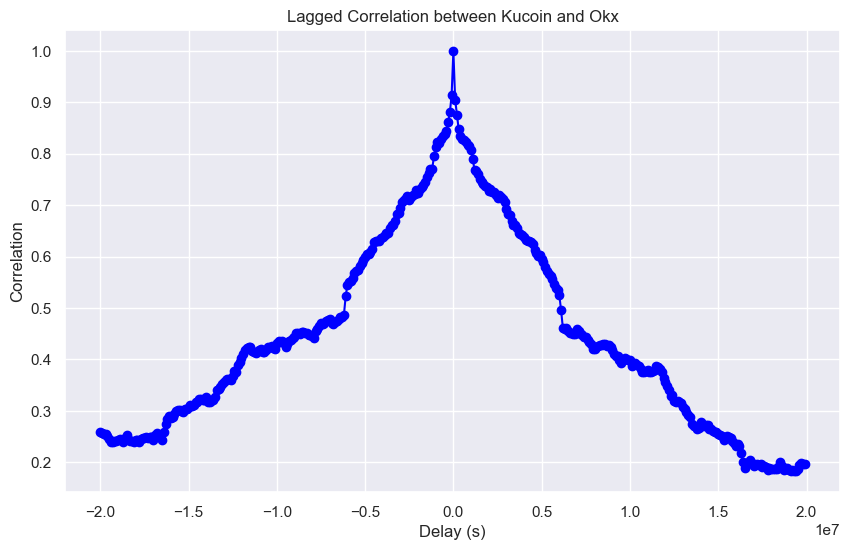

In [143]:
#Compute the laged correlation for each exchange pair and plot the results
delay_values = range(-20000000, 20000000, 100000)

binance_bybit_correlation_values, binance_bybit_p_values = compute_laged_cross_correlation(binance_df_timed_index_october, bybit_df_timed_index_october , delay_values)
plot_laged_cross_correlation('Binance', 'Bybit', binance_bybit_correlation_values)

binance_kucoin_correlation_values, binance_kucoin_p_values = compute_laged_cross_correlation(binance_df_timed_index_october, kucoin_df_timed_index_october , delay_values)
plot_laged_cross_correlation('Binance', 'Kucoin', binance_kucoin_correlation_values)

binance_okx_correlation_values, binance_okx_p_values = compute_laged_cross_correlation(binance_df_timed_index_october, okx_df_timed_index_october , delay_values)
plot_laged_cross_correlation('Binance', 'Okx', binance_okx_correlation_values)

bybit_kucoin_correlation_values, bybit_kucoin_p_values = compute_laged_cross_correlation(bybit_df_timed_index_october, kucoin_df_timed_index_october , delay_values)
plot_laged_cross_correlation('Bybit', 'Kucoin', bybit_kucoin_correlation_values)

bybit_okx_correlation_values, bybit_okx_p_values = compute_laged_cross_correlation(bybit_df_timed_index_october, okx_df_timed_index_october, delay_values)
plot_laged_cross_correlation('Bybit', 'Okx', bybit_okx_correlation_values)

kucoin_okx_correlation_values, kucoin_okx_p_values = compute_laged_cross_correlation(kucoin_df_timed_index_october, okx_df_timed_index_october , delay_values)
plot_laged_cross_correlation('Kucoin', 'Okx', kucoin_okx_correlation_values)


### Lead-lag relationships

In [155]:
optimal_delays = []

In [156]:
from pandas.tseries.offsets import MonthEnd

In [160]:
def optimal_lag (correlation_values , delay_values):

    max_correlation = max(correlation_values)
    max_correlation_index = correlation_values.index(max_correlation)
    optimal_delay = delay_values[max_correlation_index]

    return optimal_delay

In [161]:
delay_values = range(-200, 200, 10)
optimal_lags_binance_bybit = []
optimal_lags_binance_kucoin = []
optimal_lags_binance_okx = []
optimal_lags_bybit_kucoin = []
optimal_lags_bybit_okx = []
optimal_lags_kucoin_okx = []


for i in range(1, 12):  # 1 to 12 for all months
    # Start of the month string
    start_date = '2023-{:02d}-01'.format(i)
    
    # End of the month - use MonthEnd to get the last day of the month
    end_date = pd.to_datetime(start_date) + MonthEnd(1)
    
    # Slice the data for the current month
    binance_data_month_i = binance_df_timed_index.loc[start_date: end_date.strftime('%Y-%m-%d')]
    bybit_data_month_i = bybit_df_timed_index.loc[start_date: end_date.strftime('%Y-%m-%d')]
    binance_bybit_correlation_values, binance_bybit_p_values = compute_laged_cross_correlation(binance_data_month_i, bybit_data_month_i , delay_values)
    optimal_delay_binance_bybit = optimal_lag(binance_bybit_correlation_values, delay_values)
    optimal_lags_binance_bybit.append(optimal_delay_binance_bybit)

    kucoin_data_month_i = kucoin_df_timed_index.loc[start_date: end_date.strftime('%Y-%m-%d')]
    binance_kucoin_correlation_values, binance_kucoin_p_values = compute_laged_cross_correlation(binance_data_month_i, kucoin_data_month_i , delay_values)
    optimal_delay_binance_kucoin = optimal_lag(binance_kucoin_correlation_values, delay_values)
    optimal_lags_binance_kucoin.append(optimal_delay_binance_kucoin)

    okx_data_month_i = okx_df_timed_index.loc[start_date: end_date.strftime('%Y-%m-%d')]
    binance_okx_correlation_values, binance_okx_p_values = compute_laged_cross_correlation(binance_data_month_i, okx_data_month_i , delay_values)
    optimal_delay_binance_okx = optimal_lag(binance_okx_correlation_values, delay_values)
    optimal_lags_binance_okx.append(optimal_delay_binance_okx)

    bybit_kucoin_correlation_values, bybit_kucoin_p_values = compute_laged_cross_correlation(bybit_data_month_i, kucoin_data_month_i , delay_values)
    optimal_delay_bybit_kucoin = optimal_lag(bybit_kucoin_correlation_values, delay_values)
    optimal_lags_bybit_kucoin.append(optimal_delay_bybit_kucoin)

    bybit_okx_correlation_values, bybit_okx_p_values = compute_laged_cross_correlation(bybit_data_month_i, okx_data_month_i , delay_values)
    optimal_delay_bybit_okx = optimal_lag(bybit_okx_correlation_values, delay_values)
    optimal_lags_bybit_okx.append(optimal_delay_bybit_okx)

    kucoin_okx_correlation_values, kucoin_okx_p_values = compute_laged_cross_correlation(kucoin_data_month_i, okx_data_month_i , delay_values)
    optimal_delay_kucoin_okx = optimal_lag(kucoin_okx_correlation_values, delay_values)
    optimal_lags_kucoin_okx.append(optimal_delay_kucoin_okx)


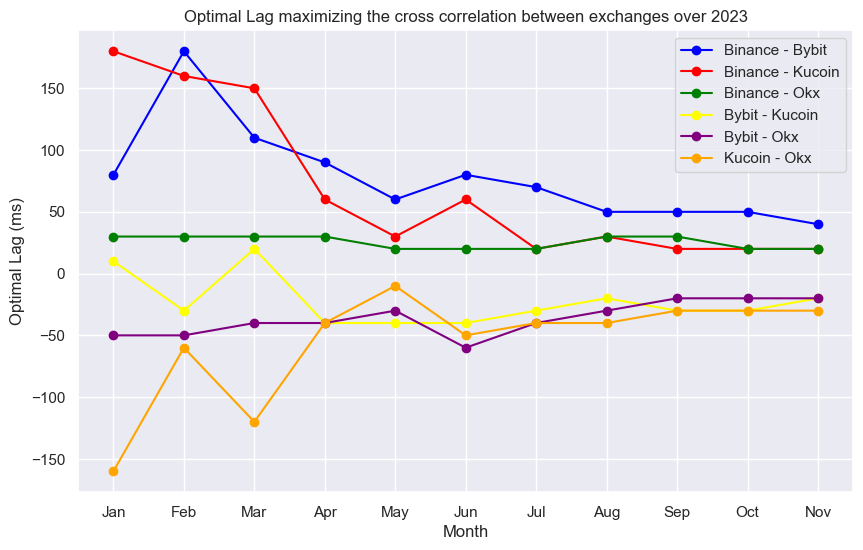

In [165]:
#plot the optimal lags for each exchange pair
plt.figure(figsize=(10, 6))  # Optional: Adjust the figure size

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct' , 'Nov']

plt.plot(months, optimal_lags_binance_bybit,  marker='o', color='blue', label='Binance - Bybit')
plt.plot(months, optimal_lags_binance_kucoin,  marker='o', color='red', label='Binance - Kucoin')
plt.plot(months, optimal_lags_binance_okx,  marker='o', color='green', label='Binance - Okx')
plt.plot(months, optimal_lags_bybit_kucoin,  marker='o', color='yellow', label='Bybit - Kucoin')
plt.plot(months, optimal_lags_bybit_okx,  marker='o', color='purple', label='Bybit - Okx')
plt.plot(months, optimal_lags_kucoin_okx,  marker='o', color='orange', label='Kucoin - Okx')

# Enhance the plot with titles and labels
plt.title('Optimal Lag maximizing the cross correlation between exchanges over 2023')
plt.xlabel('Month')
plt.ylabel('Optimal Lag (ms)')
plt.legend()
plt.show()

In [158]:
optimal_delays

[80, 180, 110, 90, 60, 80, 70, 50, 50, 50, 40]